code: https://github.com/ritts97/Unsupervised-Face-Clustering

## Setup

In [1]:
import sys
import os
import dlib
import glob
import time

import cv2
import os

import matplotlib.pyplot as plt

from face_classifier import FaceClassifier

import random
import torch
import numpy as np
import face_recognition

import calc
import icio
import postproc

from person_db import Person
from person_db import Face
from person_db import PersonDB

print(dlib.DLIB_USE_CUDA)
print(cv2.__version__)

True
4.5.5


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(79)

## Extract frame from video and save as images

In [6]:
filepath = '/opt/ml/project/input_dir/video/testvideo_2.mp4'
video = cv2.VideoCapture(filepath)

assert video.isOpened(), f"Could not Open : {filepath}"

In [7]:
# 불러온 비디오 파일의 정보 출력
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 28390
width : 1280
height : 720
fps : 29.97002997002997


In [8]:
# 변수 설정
frame_batch_size = 16
frame_id = 0
capture_interval = 2 * int(round(fps)) # n초 간격 프레임 캡쳐
stop = 300 # 0 초과의 정수 지정 시 n 초 까지만 영상 실행
skip = 0 # 초반 n 초 skip
capture_cnt = 60 # 몇 장의 frame을 capture 할 지
threshold = 0.36 # 같은 인물로 판단할 threshold -> 낮을수록 같은 인물로 판단하지 않음
ratio = 1.0 # resizing ratio인데, 건드리지 않는게 좋을 듯
running = True

In [9]:
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18_'
# pdb = PersonDB()
# pdb.load_db(result_dir)
# pdb.print_persons()

In [10]:
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print('Error: Creaing directory. ' + result_dir)

**dnn_superres 사용**
```
pip uninstall opencv-python
pip uninstall opencv-contrib-python
pip3 install opencv-contrib-python
```
- 코드 및 성능비교표: https://learnopencv.com/super-resolution-in-opencv/ 
- super resolution 모델들 & 다운로드 링크: https://github.com/opencv/opencv_contrib/blob/master/modules/dnn_superres/README.md

In [11]:
video = cv2.VideoCapture(filepath) 

# FaceClssifier 인스턴스 생성
fc = FaceClassifier(threshold, ratio, result_dir)

fingerprints = dict()

frames = []
frame_count = 0
cnt = 0

start = time.time()
while running:
    ret, frame = video.read()

    if frame is None:
        break

    seconds = int(round(frame_count / fps, 3))
    # print(f"Running in {seconds} sec in video...")
    if seconds > stop > 0:
        break
    if seconds < skip:
        continue
    if frame_count % capture_interval == 0:
        frames.append(frame)

    if len(frames) == frame_batch_size:
        # 얼굴 디텍션 -> 얼굴 인코딩(frame, face_boxes) -> 옷 디텍션 -> 옷 인코딩(read_frames 코드 + _frame_worker 코드 + get_model 코드 + fingerprint 코드) -> 이미지 저장
        # 반환: 상체 이미지(파일명): [얼굴 인코딩 | 옷 인코딩] (fingerprint)
        frame_fingerprints = fc.detect_faces(frames,frame_batch_size)
        if frame_fingerprints:
            fingerprints.update(frame_fingerprints)
            print('Face images: ', len(fingerprints))
            cnt += 1
            print('frame_cnt: ', cnt)
            print()
        
        frames = []
        
    if cnt >= capture_cnt:
        break
    
    frame_count += 1



# restore SIGINT (^C) handler
running = False
video.release()
print()

# pdb.save_db(result_dir)
# pdb.print_persons()

end = time.time()
print('Inference time: ',end-start)
print("Captured frames : ", frame_count)

image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.463-0.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.463-1.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.578-0.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.578-1.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.770-0.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.770-1.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.770-2.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.770-3.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.931-0.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.931-1.png
image saved path:  /opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.931-2.png

In [12]:
filepath = '/opt/ml/project/input_dir/video/testvideo_2.mp4'
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18_'

#images : #clusters
4 : 2
5 : 2
7 : 1
10 : 1
11 : 1
18 : 1
21 : 1
36 : 1
#images in clusters total:  121
cluster dir: /opt/ml/project/input_dir/video/testvideo_2t1/imagecluster/clusters
/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062623.178-3.png/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062608.756-1.png/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062625.743-3.png/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062606.013-0.png/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062618.333-2.png/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062613.613-0.png



/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062613.028-0.png
/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062608.756-0.png

/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062605.770-3.png/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062620.421-1.png
/opt/ml/project/input_dir/video/testvideo_2t1/20220528_062610.843-0.png/opt/ml/project/input_dir

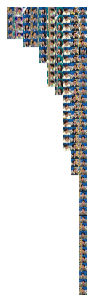

In [13]:
# 클러스터링(fingerprints) 후 결과 출력
clusters = calc_new.cluster(fingerprints, sim=0.4, min_csize=4) # 높일수록 엄격하게

postproc.make_links(clusters, os.path.join(result_dir, 'imagecluster/clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_cluster.png'))
postproc.plt.show()